In [1]:
import numpy as np
import xarray as xr
#import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import sstats.tseries as ts
from inspect import signature

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:50525 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### Internal tides without decorrelation timescales : 
x = $X_0$cos($\omega$ t)\
$C_{xx} = X_0^2 \int_0^T cos(\omega t) cos(\omega (t+\tau))dt$\
$C_{xx} = \frac{X_0^2}{T}\int_0^{T} 1/2(cos(\omega \tau)+cos(2\omega t+\omega \tau))dt$\
$C_{xx} = X_0^2/2 cos(\omega \tau)+ \frac{1}{2T}[\frac{1}{2\omega} sin(\omega t +\omega \tau]_0^{T}$

In [3]:
dt = 1/(6*24)
t = np.arange(0,500,dt)
X0 = 1
omega = 2*np.pi*2 
x = xr.DataArray(X0*np.cos(omega*t),dims={'time'},coords={'time':t})
x.name= 'itide'

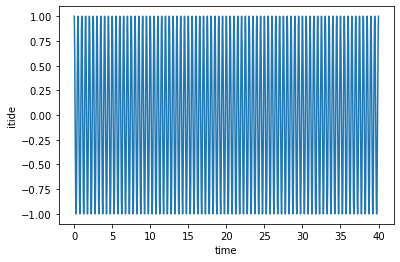

In [45]:
x.sel(time=slice(0,40)).plot()

In [46]:
xx = np.correlate(x,x,mode='same')
xx = xx[int(x.size/2):]

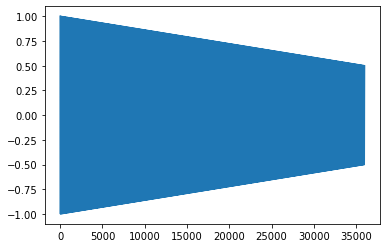

In [47]:
plt.plot(xx/xx[0])

In [4]:
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1#.transpose((2,1,0))
        v2 = v2#.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'same'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'same','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv#.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1, _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)

In [5]:
#lags, _ = correlate_E(x, x, dt, roll=True, Nr=int(T/dt),detrend=False)
def wrap_correlate(x, T,dt):
    lags,xx = correlate_E(x,x,dt=dt,roll=True,detrend=False,Nr=int(T/dt),ufunc=False)
    return xr.Dataset(data_vars={'C':(['lags','Tw'],xx.reshape(lags.size,1))} ,coords={'lags':lags,'Tw':np.array([T])})

In [90]:
tst = wrap_correlate(x,40,dt)

In [96]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])
res = xr.concat([wrap_correlate(x,T,dt) for T in Tw],dim='Tw')

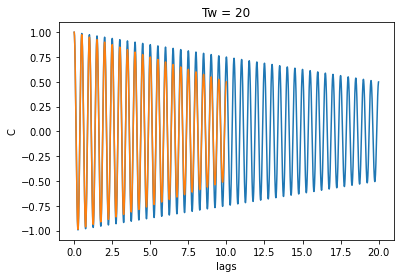

In [105]:
res['C'].sel(Tw=40).plot()
res['C'].sel(Tw=20).plot()

In [145]:
def C_t(t,Td):
    return np.exp(-t/Td)*np.cos(omega*t)

<xarray.DataArray 'C' (lags: 1440)>
array([1.        , 0.9955029 , 0.98343469, ..., 0.48499628, 0.49377694,
       0.49878915])
Coordinates:
  * lags     (lags) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
    Tw       int64 20

In [150]:
T = 40
pa,cov = scipy.optimize.curve_fit(C_t,res.sel(Tw=T).dropna(dim='lags').lags.values,res['C'].sel(Tw=T).dropna(dim='lags'),
                                 bounds=(0,500))

[32.30250018]


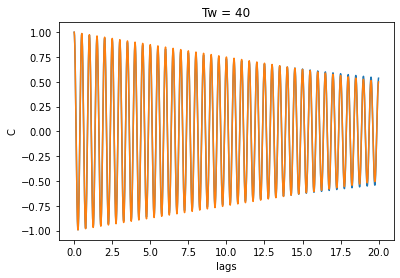

In [151]:
plt.plot(res.sel(Tw=T).dropna(dim='lags').lags.values,C_t(res.sel(Tw=T).dropna(dim='lags').lags.values,pa))
res['C'].sel(Tw=T).dropna(dim='lags').plot()
print(pa)

In [4]:
Tw = 500
Nw = 5
Tl = 1000

In [5]:
def exp_autocorr(name):
    x = (ts.exp_autocorr((Tw, 1./24), 
                         [Tl for _ in range(Nw)], 
                         1, 
                         draws=100, 
                         name=name
                        )
         .rename({'tau':'windows'})
         .assign_coords(windows=np.arange(Nw))
        )
    return x

In [6]:
xtilde = exp_autocorr('xt').persist()
ytilde = exp_autocorr('yt').persist()
omega = 2*np.pi*2

#ztilde = np.real((0.+xtilde)*np.cos(omega*xtilde.time)+1j*ytilde*np.sin(omega*xtilde.time)).rename('ztilde')#.persist()
ztilde = (np.real((0.+xtilde+1j*ytilde)
                 *np.exp(1j*omega*xtilde.time)
                )
          .rename('ztilde')
         )#.persist()

In [7]:
ztilde

<xarray.DataArray 'ztilde' (windows: 5, draw: 100, time: 12000)>
dask.array<real, shape=(5, 100, 12000), dtype=float64, chunksize=(5, 100, 12000), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0

In [8]:
ztilde.load()

<xarray.DataArray 'ztilde' (windows: 5, draw: 100, time: 12000)>
array([[[-9.63996727e-03, -2.55500215e-02, -9.69746715e-03, ...,
          2.51424948e-01,  5.48706251e-01,  7.19480042e-01],
        [ 1.33143274e-02,  1.11918473e-02,  1.91186080e-02, ...,
         -6.10307788e-01, -5.30784737e-01, -3.07574099e-01],
        [-1.07233235e-02, -1.77420795e-02, -1.80315536e-02, ...,
          4.52949803e-01,  5.01695966e-01,  3.93970950e-01],
        ...,
        [ 3.11296314e-04,  6.34531405e-03,  2.04238635e-02, ...,
          1.92336771e+00,  1.62095086e+00,  8.76635411e-01],
        [-1.93702584e-04,  1.23485012e-02,  2.20164007e-02, ...,
         -1.61470348e+00, -1.84636372e+00, -1.60055817e+00],
        [ 2.87514901e-03,  2.94312137e-03,  9.77344630e-03, ...,
         -2.17977632e-01, -2.40584288e-01, -1.87807631e-01]],

       [[-6.91668219e-03,  3.80159515e-03,  4.99072554e-03, ...,
          8.43828792e-02,  2.76152353e-01,  3.96254793e-01],
        [ 4.95427226e-03,  1.93275159e-02,  2.21198421e-02, ...,
          4.41940404e-01,  1.18151552e+00,  1.59736335e+00],
        [ 3.26286706e-03, -5.14480797e-03, -1.04257768e-02, ...,
          1.22113026e+00,  1.41428831e+00,  1.23761234e+00],
        ...,
        [-8.97603284e-03, -4.20121410e-03,  1.53133092e-02, ...,
          1.57268418e+00,  1.64182771e+00,  1.27979029e+00],
        [-4.84256617e-03, -1.00331067e-02, -3.87172377e-02, ...,
         -8.76635014e-01, -1.15326815e+00, -1.10931378e+00],
        [-2.25802626e-03,  3.26061067e-03,  6.52392482e-04, ...,
         -5.08163756e-01, -4.41902061e-01, -2.41039952e-01]],

       [[-1.71950044e-02, -1.23164208e-02, -1.83830209e-03, ...,
         -1.04962950e-01, -2.74233551e-01, -3.77119444e-01],
        [ 3.84253438e-05, -3.40275775e-03, -5.27067462e-03, ...,
          3.66715571e-01,  6.36222152e-01,  7.48409859e-01],
        [-6.51821453e-03, -5.48687493e-03,  2.63772404e-03, ...,
         -1.52032562e-02,  1.52799917e-01,  2.65464704e-01],
        ...,
        [-6.63371748e-03, -1.10454135e-02, -1.16548127e-03, ...,
          6.89938232e-01,  8.59027993e-01,  7.95919771e-01],
        [ 2.85742964e-02,  1.78262219e-02,  5.86408808e-03, ...,
         -1.11951754e+00, -8.02648486e-01, -2.87196005e-01],
        [-1.63338031e-02, -3.95988178e-02, -3.86217817e-02, ...,
          1.68078672e+00,  1.90754301e+00,  1.61341025e+00]],

       [[ 3.30025350e-03,  4.51971731e-03,  1.93247497e-02, ...,
         -1.57175725e-02, -1.70719955e-02, -1.04299515e-02],
        [-9.14905275e-04,  1.94816047e-03, -1.32283040e-02, ...,
          1.84338244e+00,  1.66030026e+00,  1.04039156e+00],
        [-3.08624355e-03, -1.31327782e-02, -4.06057266e-02, ...,
         -1.26503385e+00, -8.22235607e-01, -1.51152592e-01],
        ...,
        [ 5.76747351e-03, -1.93935227e-02, -1.17699184e-02, ...,
         -6.62394045e-01, -4.37647336e-01, -8.34679229e-02],
        [-1.25001228e-03,  9.45494824e-03,  1.11227515e-02, ...,
         -1.17365340e+00, -1.92268757e+00, -2.17242530e+00],
        [-8.54070916e-03, -4.73843478e-03,  2.89756353e-03, ...,
          1.01488609e+00,  2.55327400e-01, -5.76488573e-01]],

       [[ 4.10602123e-03, -1.03531950e-02, -1.40875896e-02, ...,
         -3.95453649e-01,  1.95142696e-02,  4.24499626e-01],
        [ 5.90162828e-03, -6.41522038e-03, -4.17267498e-03, ...,
          6.66679748e-01,  5.33107484e-01,  2.79850515e-01],
        [ 4.65966869e-03,  4.68110726e-03,  2.12543053e-02, ...,
         -2.82959457e-01,  4.00650975e-01,  9.68857144e-01],
        ...,
        [-1.42189126e-02, -8.34932645e-03, -7.30690971e-03, ...,
         -5.14630048e-01, -1.64008151e-01,  2.50454302e-01],
        [ 2.21249881e-02,  1.05302541e-02,  1.05796594e-02, ...,
         -7.52362157e-02, -2.12536444e-01, -2.87569016e-01],
        [-1.05058120e-02, -7.36511396e-03,  1.01458545e-02, ...,
         -1.78655657e+00, -1.43419803e+00, -6.99476005e-01]]])
Coordinates:
  * windows  (windows) int64 0 1 2 3 4
  * draw     (draw) int64 0 

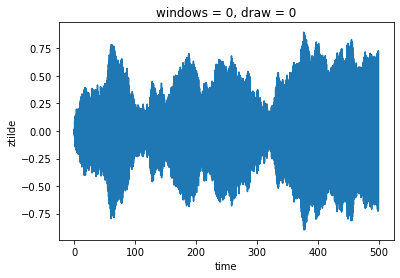

In [9]:
ztilde.isel(windows=0,draw=0).plot()

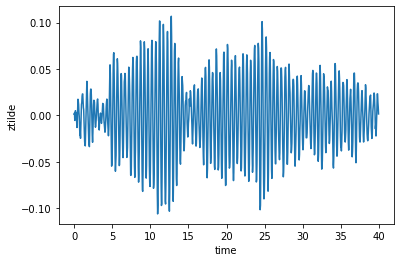

In [12]:
ztilde.mean(['windows','draw']).plot()

In [21]:
tst_synth_cov =np.correlate(ztilde.mean(['windows','draw']),ztilde.mean(['windows','draw']),mode='same')

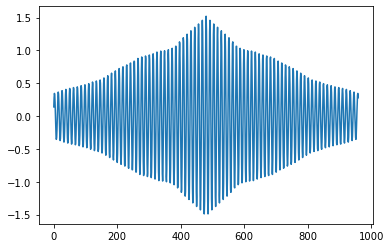

In [23]:
plt.plot(tst_synth_cov)

In [15]:
ts.correlate(ztilde.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,1)),
                      ztilde.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,1)),detrend='False')#.persist()

IndexError: index 1 is out of bounds for axis 0 with size 0

In [156]:
def param_fit(x,myfunc,Tw,Nw,n,X = 'normalized',detrend=False):
    """Compute the autocorrelation function of a dataset x with time window size, Tw and number of segments, Nw 
    and find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Dataset to use to compute the autocorrleation
        myfunc: func
                Function used for the fit
        Tw: int
            Time window size
        Nw: int
            Number of segments
        n : int
            Number of draws
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    xx = ts.correlate(x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),
                      x.sel(time=slice(100,Tw+100)).isel(windows=slice(0,Nw),draw=slice(0,n)),detrend=detrend).persist()
    if X=='normalized':
        xx = xx/xx.sel(lags=0) 
    else :
        pass
    pa = np.full((xx.draw.size,len(sig.parameters)-1),np.nan)#,np.full((xx.draw.size,len(sig.parameters)-1),np.nan)
    #true_val=[Tl]
    for i in range(xx.draw.size):
        pa[i,:],co = scipy.optimize.curve_fit(myfunc,xx.lags,xx.isel(draw=i).mean(['windows']))
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = xr.Dataset({'params':(['draws','param'],pa)},
                     coords={"draws":np.arange(0,n,1),'param':[V for V in sig.parameters.keys()][1:]})
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [164]:
ztilde = ztilde.persist()
ztilde_real = np.real(ztilde).persist()

In [165]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])#np.arange(20,350,50)#[40,80,100,200]
Nw = np.arange(1,50,10)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(np.real(ztilde),C_t,T,nt,100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out['Nw'] = Nw
out['Tw'] = Tw

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-30f6d20515f9fcc2a575cb33047e53ed', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-30f6d20515f9fcc2a575cb33047e53ed', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-30f6d20515f9fcc2a575cb33047e53ed', 0)": ()}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-9ec5a61ba7789e08ec06177bc1dfa3c4', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-9ec5a61ba7789e08ec06177bc1dfa3c4', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-9ec5a61ba7789e08ec06177bc1dfa3c4', 0)": ()}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-938f1a1e7857274b430828595a035ac8', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler -

In [171]:
out.params.mean('draws')

<xarray.DataArray 'params' (Tw: 10, Nw: 5, param: 1)>
array([[[ 5.94365736],
        [ 5.09216544],
        [ 5.06792779],
        [ 5.05377725],
        [ 5.03732363]],

       [[ 8.41493578],
        [ 6.7235507 ],
        [ 6.74768443],
        [ 6.7155096 ],
        [ 6.70473771]],

       [[ 9.23025217],
        [ 7.5475167 ],
        [ 7.51555638],
        [ 7.57992969],
        [ 7.55444716]],

       [[ 9.64231071],
        [ 8.16794183],
        [ 8.08581749],
        [ 8.11516753],
        [ 8.07782336]],

       [[10.3132925 ],
        [ 8.53234037],
        [ 8.45593417],
        [ 8.46291451],
        [ 8.42345031]],

       [[10.73508275],
        [ 8.76314293],
        [ 8.68547887],
        [ 8.71225515],
        [ 8.66603804]],

       [[10.45102805],
        [ 9.05175123],
        [ 9.0052787 ],
        [ 9.0369458 ],
        [ 9.0145922 ]],

       [[10.27558454],
        [ 9.22442218],
        [ 9.20098457],
        [ 9.20812038],
        [ 9.18745379]],

       [[10.0506616 ],
        [ 9.33725714],
        [ 9.2917391 ],
        [ 9.30845463],
        [ 9.28968461]],

       [[ 9.8557043 ],
        [ 9.36737707],
        [ 9.36263642],
        [ 9.38641225],
        [ 9.37203333]]])
Coordinates:
  * param    (param) <U2 'Td'
  * Nw       (Nw) int64 1 11 21 31 41
  * Tw       (Tw) int64 20 40 60 80 100 120 170 220 270 320

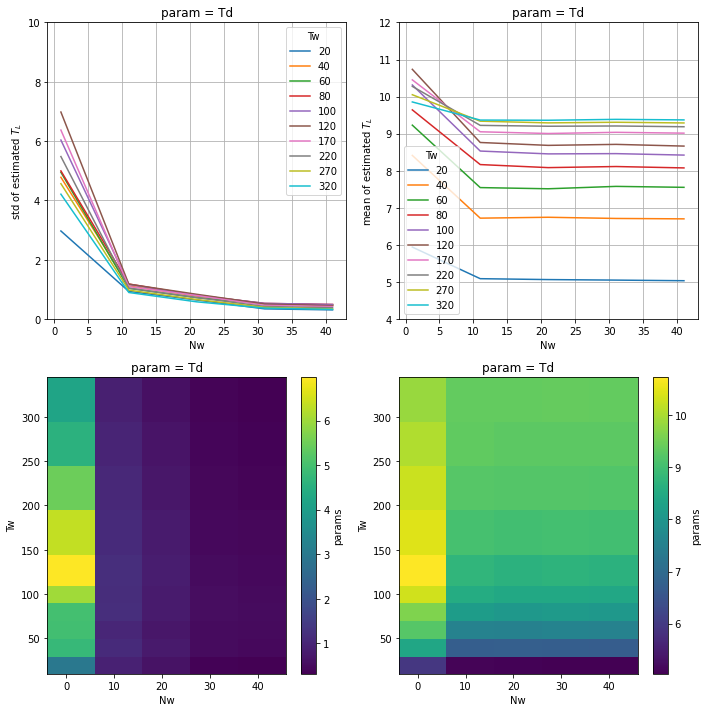

In [172]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out['params'].sel(param='Td').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out['params'].sel(param='Td').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out['params'].sel(param='Td').std('draws').plot(ax=axes[1,0])
out['params'].sel(param='Td').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()

fig.tight_layout()

In [176]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])#np.arange(20,350,50)#[40,80,100,200]
Nw = np.arange(1,50,10)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(np.real(ztilde),C_t,T,nt,100,X='')for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out['Nw'] = Nw
out['Tw'] = Tw

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-44a89017e6dfeebb3d03180f82f51bbb', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-44a89017e6dfeebb3d03180f82f51bbb', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-44a89017e6dfeebb3d03180f82f51bbb', 0)": ()}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-1da7978ccb28d881fbe4376e126614f1', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-1da7978ccb28d881fbe4376e126614f1', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-1da7978ccb28d881fbe4376e126614f1', 0)": ()}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-78ca5d55996d3c43641844a4b7fdf856', 0)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler -

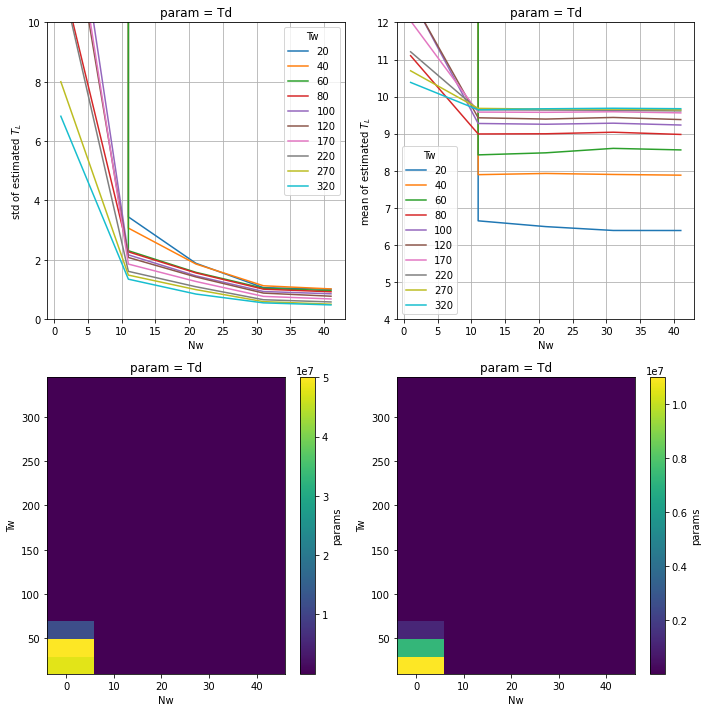

In [177]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
out['params'].sel(param='Td').std('draws').plot.line(ax=axes[0,0],x='Nw');axes[0,0].set_ylabel(r'std of estimated $T_L$')
out['params'].sel(param='Td').mean('draws').plot.line(ax=axes[0,1],x='Nw');axes[0,1].set_ylabel(r'mean of estimated $T_L$')
axes[0,0].set_ylim(0,10);axes[0,1].set_ylim(4,12)
out['params'].sel(param='Td').std('draws').plot(ax=axes[1,0])
out['params'].sel(param='Td').mean('draws').plot(ax=axes[1,1])
axes[0,0].grid();axes[0,1].grid()

fig.tight_layout()

In [173]:
Tw = 500
Nw = 50
Tl = 20

In [174]:

xtilde = exp_autocorr('xt').persist()
ytilde = exp_autocorr('yt').persist()
omega = 2*np.pi*2

#ztilde = np.real((0.+xtilde)*np.cos(omega*xtilde.time)+1j*ytilde*np.sin(omega*xtilde.time)).rename('ztilde')#.persist()
ztilde = (np.real((0.+xtilde+1j*ytilde)
                 *np.exp(1j*omega*xtilde.time)
                )
          .rename('ztilde')
         )#.persist()

In [175]:
ztilde = ztilde.persist()
ztilde_real = np.real(ztilde).persist()

In [ ]:
Tw = np.hstack([np.arange(20,120,20),np.arange(120,350,50)])#np.arange(20,350,50)#[40,80,100,200]
Nw = np.arange(1,50,10)#[2,5,10,20,30]
out = xr.combine_nested([[param_fit(np.real(ztilde),C_t,T,nt,100)for T in Tw] for nt in Nw],concat_dim=['Nw','Tw'])
out['Nw'] = Nw
out['Tw'] = Tw

In [ ]:
cluster.close()